In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

/Users/takeshi/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


## 学習

In [2]:
df = pd.read_csv('train.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,52,services,married,secondary,no,108,yes,no,unknown,15,may,543,12,-1,0,unknown,no
1,35,admin.,married,unknown,no,1055,no,no,cellular,2,mar,59,2,-1,0,unknown,no
2,37,blue-collar,married,secondary,no,32,yes,no,unknown,20,may,146,2,-1,0,unknown,no
3,57,unemployed,married,primary,no,2743,no,no,cellular,29,jan,89,1,-1,0,unknown,no
4,42,self-employed,married,tertiary,no,6383,no,no,cellular,27,aug,111,5,-1,0,unknown,no


## データ確認
参考URL：https://ohke.hateblo.jp/entry/2017/08/04/230000

In [3]:
df['y'].value_counts()

no     35952
yes     4737
Name: y, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11cb1d1d0>,
      dtype=object)

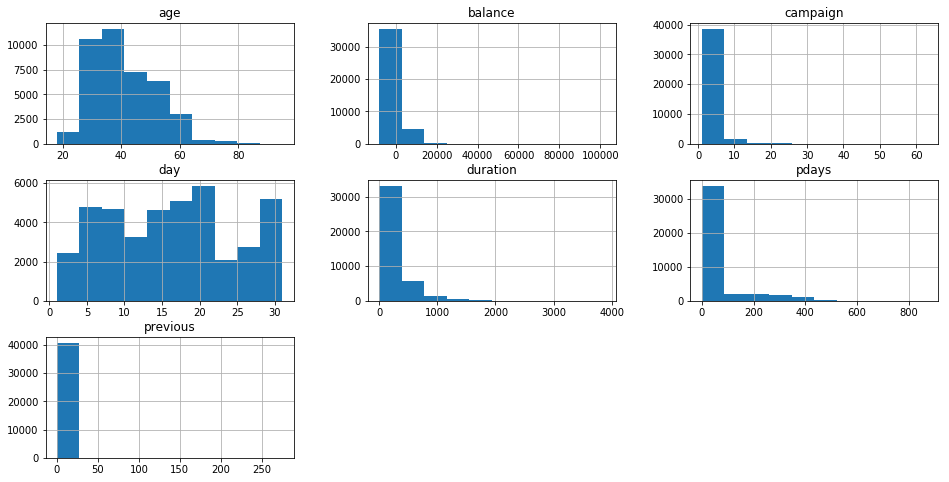

In [4]:
df.hist(figsize=(16,8))

In [6]:
# カテゴリ系の特徴量に含まれる値を確認
for col in df.columns:
    if not isinstance(df[col][0],str):
        continue
    print('({})'.format(col))
    print('{}'.format(np.unique(df[col].values)))

(job)
['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed' 'unknown']
(marital)
['divorced' 'married' 'single']
(education)
['primary' 'secondary' 'tertiary' 'unknown']
(default)
['no' 'yes']
(housing)
['no' 'yes']
(loan)
['no' 'yes']
(contact)
['cellular' 'telephone' 'unknown']
(month)
['apr' 'aug' 'dec' 'feb' 'jan' 'jul' 'jun' 'mar' 'may' 'nov' 'oct' 'sep']
(poutcome)
['failure' 'other' 'success' 'unknown']
(y)
['no' 'yes']


In [5]:
def create_feature_df(input_df):
    # 各特徴量の相関係数を可視化
    features_df = pd.DataFrame()

    # 目的変数
    features_df['y'] = input_df['y'].apply(lambda s : 1 if s == 'yes' else 0)

    # 連続値
    features_df['age'] = input_df['age']
    features_df['balance'] = input_df['balance']
    features_df['day'] = input_df['day']
    features_df['duration'] = input_df['duration']
    features_df['campaign'] = input_df['campaign']
    features_df['pdays'] = input_df['pdays']
    features_df['previous'] = input_df['previous']

    # ２値
    features_df['default'] = input_df['default'].apply(lambda s : 1 if s=='yes' else 0)
    features_df['housing'] = input_df['housing'].apply(lambda s : 1 if s=='yes' else 0)
    features_df['loan'] = input_df['loan'].apply(lambda s : 1 if s=='yes' else 0)

    # カテゴリ
    features_df['job'],_ = pd.factorize(input_df['job'])
    features_df['marital'],_ = pd.factorize(input_df['marital'])
    features_df['education'],_ = pd.factorize(input_df['education'])
    features_df['contact'],_ = pd.factorize(input_df['contact'])
    features_df['month'],_ = pd.factorize(input_df['month'])
    features_df['poutcome'],_ = pd.factorize(input_df['poutcome'])
    
    return features_df

In [6]:
def get_features(df):
    # 特徴量として使う連続量
    features_ana = ['age', 'balance','day','duration','campaign','pdays','previous']
    # 連続値として使うカテゴリ値
    features_dig = ['job', 'housing','default','loan','marital','education','contact','month','poutcome']
    X = np.concatenate(
        [df[features_ana].values, pd.get_dummies(df[features_dig]).values],
        axis=1)
    return X

def get_label(df):
    y = df['y'].replace({'yes': 1, 'no': 0}).values
    return y

## モデル構築

In [51]:
def create_linearsvc_model_and_fit(target_df):
    features_df = create_feature_df(target_df)
    X = features_df.drop('y',axis=1).values
    y = get_label(target_df)

    lsvc = LinearSVC(penalty='l1', loss='squared_hinge', dual=False, tol=1e-3,C=0.05)
    lsvc.fit(X,y)
    # 評価
    print('Train score: {}'.format(lsvc.score(X, y)))
    print('Confusion matrix:\n{}'.format(confusion_matrix(y, lsvc.predict(X))))
    print('f1 score: {:.3f}'.format(f1_score(y, lsvc.predict(X))))
    return lsvc

In [52]:
# 特徴量, ラベルを作成
X = get_features(df)
y = get_label(df)
lsvc = create_linearsvc_model_and_fit(df)

Train score: 0.8975890289758903
Confusion matrix:
[[35352   600]
 [ 3567  1170]]
f1 score: 0.360


## テスト

In [53]:
test_df = pd.read_csv('test.csv')

In [54]:
test_X = create_feature_df(test_df).drop('y',axis=1).values
test_y = get_label(test_df)
print('Test score: {}'.format(lsvc.score(test_X, test_y)))
print('Confusion matrix:\n{}'.format(confusion_matrix(test_y, lsvc.predict(test_X))))
print('f1 score: {:.3f}'.format(f1_score(test_y, lsvc.predict(test_X))))
pred_lsvc =lsvc.predict(test_X)
print(accuracy_score(test_y,pred_lsvc))

Test score: 0.8907563025210085
Confusion matrix:
[[3881   89]
 [ 405  147]]
f1 score: 0.373
0.8907563025210085


In [55]:
# 外れ値データを外したCSVファイルでやってみる
dropped_train_df = pd.read_csv('dropped_outliers_train.csv')
# 特徴量, ラベルを作成
X = get_features(dropped_train_df)
y = get_label(dropped_train_df)
lsvc_dropped = create_linearsvc_model_and_fit(dropped_train_df)

# テスト
test_df = pd.read_csv('test.csv')
test_X = create_feature_df(test_df).drop('y',axis=1).values
test_y = get_label(test_df)
print('Test score: {}'.format(lsvc_dropped.score(test_X, test_y)))
print('Confusion matrix:\n{}'.format(confusion_matrix(test_y, lsvc_dropped.predict(test_X))))
print('f1 score: {:.3f}'.format(f1_score(test_y, lsvc_dropped.predict(test_X))))
pred_lsvc_test =lsvc_dropped.predict(test_X)
print(accuracy_score(test_y,pred_lsvc_test))

Train score: 0.8975708103855232
Confusion matrix:
[[35339   599]
 [ 3567  1167]]
f1 score: 0.359
Test score: 0.8900928792569659
Confusion matrix:
[[3880   90]
 [ 407  145]]
f1 score: 0.368
0.8900928792569659


In [10]:
# accuracy
pred = model.predict(test_X).reshape(-1)
pred = (pred > 0.5).astype(int)

In [13]:
# test ARI (この値を報告してください)
accuracy_score(test_y, pred)

0.8781512605042017

# グリッドサーチでパラメータ探索

In [67]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'C':[0.1,0.5,1, 3, 5],
    'loss':('hinge', 'squared_hinge'),
    #'penalty':('l1','l2')
}
clf = GridSearchCV(LinearSVC(), parameters,cv=3,verbose=3)
clf.fit(X,y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=0.1, loss=hinge ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV] ...... C=0.1, loss=hinge, score=0.8256379997049712, total=   5.5s
[CV] C=0.1, loss=hinge ...............................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s


[CV] ...... C=0.1, loss=hinge, score=0.8951095375082982, total=   5.4s
[CV] C=0.1, loss=hinge ...............................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ...... C=0.1, loss=hinge, score=0.8985763812052814, total=   5.4s
[CV] C=0.1, loss=squared_hinge .......................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=0.1, loss=squared_hinge, score=0.8429709396666175, total=   5.4s
[CV] C=0.1, loss=squared_hinge .......................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=0.1, loss=squared_hinge, score=0.8768164048093235, total=   5.5s
[CV] C=0.1, loss=squared_hinge .......................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=0.1, loss=squared_hinge, score=0.8895035774876447, total=   5.4s
[CV] C=0.5, loss=hinge ...............................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ...... C=0.5, loss=hinge, score=0.7434724885676354, total=   5.4s
[CV] C=0.5, loss=hinge ...............................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ...... C=0.5, loss=hinge, score=0.8907575422291067, total=   5.4s
[CV] C=0.5, loss=hinge ...............................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ...... C=0.5, loss=hinge, score=0.8998303459467434, total=   5.5s
[CV] C=0.5, loss=squared_hinge .......................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=0.5, loss=squared_hinge, score=0.5621773122879481, total=   5.6s
[CV] C=0.5, loss=squared_hinge .......................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=0.5, loss=squared_hinge, score=0.8411890536254334, total=   6.1s
[CV] C=0.5, loss=squared_hinge .......................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=0.5, loss=squared_hinge, score=0.8929704211846279, total=   6.1s
[CV] C=1, loss=hinge .................................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ........ C=1, loss=hinge, score=0.6522348428971825, total=   5.5s
[CV] C=1, loss=hinge .................................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... C=1, loss=hinge, score=0.741461975363281, total=   5.4s
[CV] C=1, loss=hinge .................................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ......... C=1, loss=hinge, score=0.887216935900273, total=   5.4s
[CV] C=1, loss=squared_hinge .........................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1, loss=squared_hinge, score=0.8603038796282637, total=   5.8s
[CV] C=1, loss=squared_hinge .........................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1, loss=squared_hinge, score=0.7081212657667626, total=   5.9s
[CV] C=1, loss=squared_hinge .........................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=1, loss=squared_hinge, score=0.4461163974330604, total=   6.0s
[CV] C=3, loss=hinge .................................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ........ C=3, loss=hinge, score=0.7996754683581649, total=   5.4s
[CV] C=3, loss=hinge .................................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ........ C=3, loss=hinge, score=0.8903149664380025, total=   5.7s
[CV] C=3, loss=hinge .................................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ........ C=3, loss=hinge, score=0.8895035774876447, total=   6.3s
[CV] C=3, loss=squared_hinge .........................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=3, loss=squared_hinge, score=0.8673108128042484, total=   6.4s
[CV] C=3, loss=squared_hinge .........................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=3, loss=squared_hinge, score=0.8891347643283912, total=   6.6s
[CV] C=3, loss=squared_hinge .........................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=3, loss=squared_hinge, score=0.8822748395662757, total=   6.6s
[CV] C=5, loss=hinge .................................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ........ C=5, loss=hinge, score=0.8942321876382947, total=   5.6s
[CV] C=5, loss=hinge .................................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ........ C=5, loss=hinge, score=0.8949620122445969, total=   5.8s
[CV] C=5, loss=hinge .................................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ........ C=5, loss=hinge, score=0.7163826805340414, total=   5.5s
[CV] C=5, loss=squared_hinge .........................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=5, loss=squared_hinge, score=0.8440035403451837, total=   5.5s
[CV] C=5, loss=squared_hinge .........................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  C=5, loss=squared_hinge, score=0.8386811241425094, total=   5.4s
[CV] C=5, loss=squared_hinge .........................................


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.9min finished


[CV] . C=5, loss=squared_hinge, score=0.891937744338718, total=   5.6s


/Users/takeshi/.local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 0.5, 1, 3, 5], 'loss': ('hinge', 'squared_hinge')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [70]:
test_X_gridsearch = get_features(test_df)
clf.best_estimator_.score(test_X_gridsearch,test_y)

0.6410880141530296